Rameesha - MSDS - 24F-8014

**Task 1: Encoder Model (BERT) — Emotion Detection from Text**

**Problem:**
Perform	multi-class	text	classification	to	predict	emotions	(such	as	joy,	sadness,	anger,	and
neutral)	from	textual	data.

---


**Dataset:**
https://www.kaggle.com/datasets/faiqahmad01/emotion-categories
neutral-joy-sadness-anger

---


**Objective:**
Fine-tune	a	pre-trained	BERT	model	(such	as	'bert-base-uncased')	to	detect	emotions	from
sentences.

---

**Deliverables:**
* Preprocessing	and	tokenization	script
* Training	and	validation	pipeline
* Evaluation	metrics	(accuracy,	F1-score,	confusion	matrix)
* Example	predictions

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import Dataset
import json
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**dataset load**

In [ ]:
dataset_path = '/content/drive/MyDrive/ANLP/project_2/task_1/emotions-dataset.csv'
labels_path = '/content/drive/MyDrive/ANLP/project_2/task_1/emotion_labels.csv'

df = pd.read_csv(dataset_path)
print(f"total dataset: {len(df)} ")

emotion_labels = pd.read_csv(labels_path)
print("\ndataset labels:")
for _, row in emotion_labels.iterrows():
    print(f"   {row['label']}: {row['emotion']}")

emotions = dict(zip(emotion_labels['label'], emotion_labels['emotion']))
print(f"\nmy dataset has {len(emotions)} emotions: {list(emotions.values())}")

print(f"\ncolumn names: {df.columns.tolist()}")
print("few examples:")
print(df.head())

print("\nclass distribution:")
class_counts = df['sentiment'].value_counts()
for label, count in class_counts.items():
    print(f"   {emotions[label]}: {count} samples ({count/len(df)*100:.1f}%)")


total dataset: 22050 

dataset labels:
   0: Joy
   1: Sadness
   2: Neutral
   3: Anger

my dataset has 4 emotions: ['Joy', 'Sadness', 'Neutral', 'Anger']

column names: ['content', 'sentiment']
few examples:
                                             content  sentiment
0                   not a very good day at the house          1
1  tommcfly i saw you on tues and last niiiighht ...          2
2     i dont even understand the intro to this book           3
3      happy mothers day mommy and grandma haha  ily          0
4  quotoh i got so fucked up last nightquot but u...          3

class distribution:
   Anger: 5849 samples (26.5%)
   Joy: 5827 samples (26.4%)
   Neutral: 5209 samples (23.6%)
   Sadness: 5165 samples (23.4%)


**split dataset into train, validation and test**


In [ ]:
 train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['sentiment']
)

print(f"train: {len(train_df)} :: " + f"val: {len(val_df)}  :: "+f"test: {len(test_df)}")


train: 17640 :: val: 2205  :: test: 2205


**loading bert tokenizer and model**

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
print(f"loaded done {model_name}")
print(f"vocab size: {tokenizer.vocab_size}")

unique_labels = sorted(list(emotions.keys()))
label2id = {str(label): i for i, label in enumerate(unique_labels)}
id2label = {i: emotions[unique_labels[i]] for i in range(len(unique_labels))}

num_emotions = len(emotions)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_emotions,
    id2label=id2label,
    label2id=label2id
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loaded done bert-base-uncased
vocab size: 30522


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**making custom dataset class for my data**

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


**creating train, val and test dataset objects**


In [ ]:
train_dataset = EmotionDataset(train_df['content'].values, train_df['sentiment'].values, tokenizer)
val_dataset = EmotionDataset(val_df['content'].values, val_df['sentiment'].values, tokenizer)
test_dataset = EmotionDataset(test_df['content'].values, test_df['sentiment'].values, tokenizer)

print("datasets done")
print(f"train: {len(train_dataset)} | val: {len(val_dataset)} | test: {len(test_dataset)}")


datasets done
train: 17640 | val: 2205 | test: 2205


**for gpu**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
if device.type == 'cuda':
    print(f"gpu: {torch.cuda.get_device_name(0)}")
    print(f"memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("training on cpu will be slow")


device: cuda
gpu: Tesla T4
memory: 15.83 GB


**training setup**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

training_config = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    logging_dir='./logs',
    seed=42,
    report_to=[]
)

print(f"training setup done  {training_config.num_train_epochs} epochs, batch size {training_config.per_device_train_batch_size}")


training setup done  3 epochs, batch size 16


**defining metrics function**

In [ ]:
def calculate_metrics(pred):
    predictions, labels = pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    f1_weighted = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

print("metrics function done")


metrics function done


**model training**

In [ ]:
trainer = Trainer(
    model=model,
    args=training_config,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=calculate_metrics
)


training_results = trainer.train()
print("training done!")
print(f"total time: {training_results.metrics['train_runtime']/60:.1f} min")
print(f"final loss: {training_results.metrics['train_loss']:.4f}")


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.880300,0.842066,0.664399,0.668112,0.668640
2,0.742100,0.820216,0.673923,0.672975,0.673516
3,0.535300,0.905422,0.671202,0.669618,0.670592


training done!
total time: 8.6 min
final loss: 0.7670


**saving my model and tokenizer**

In [ ]:
model.save_pretrained('/content/drive/MyDrive/ANLP/project_2/task_1/my_bert_emotion_model')
tokenizer.save_pretrained('/content/drive/MyDrive/ANLP/project_2/task_1/my_bert_emotion_model')
print("model and tokenizer saved in '/content/drive/MyDrive/ANLP/project_2/task_1/my_bert_emotion_model'")


model and tokenizer saved in '/content/drive/MyDrive/ANLP/project_2/task_1/my_bert_emotion_model'


**model evalution**

In [ ]:
test_results = trainer.evaluate(test_dataset)
print("\nfinal test results:")
print(f"accuracy: {test_results['eval_accuracy']:.4f}")
print(f"f1_macro: {test_results['eval_f1_macro']:.4f}")
print(f"f1_weighted: {test_results['eval_f1_weighted']:.4f}")


final test results:
accuracy: 0.6635
f1_macro: 0.6616
f1_weighted: 0.6625


**predictions and confusion matrix**

confusion matrix saved  '/content/drive/MyDrive/ANLP/project_2/task_1/confusion_matrix.png'


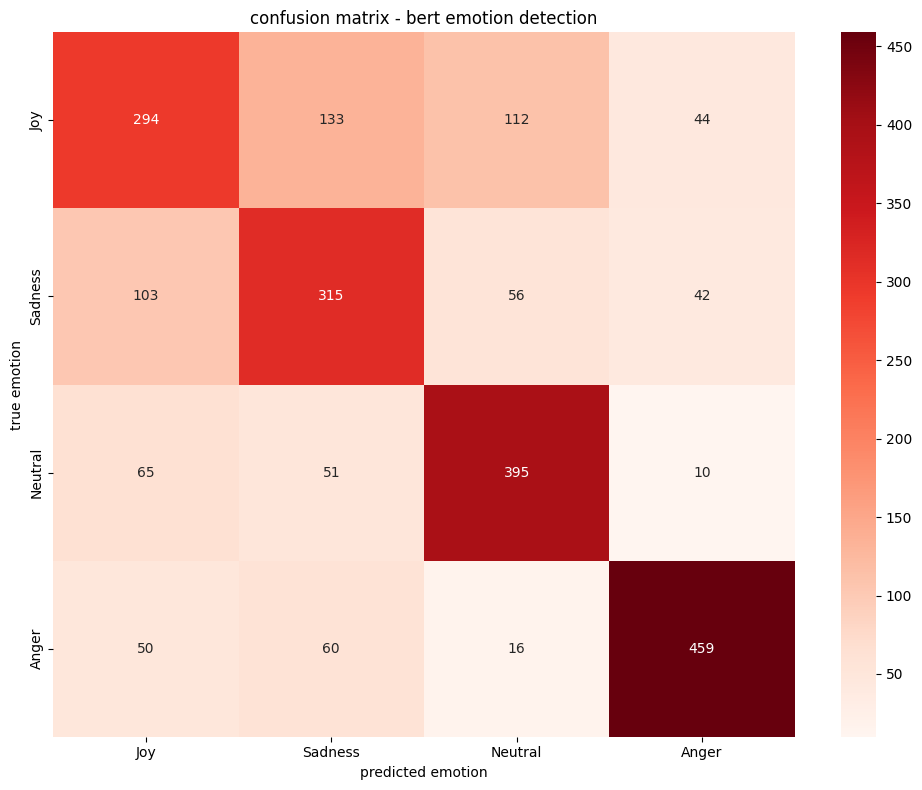

In [ ]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_df['sentiment'].values

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=[emotions[i] for i in range(num_emotions)],
    yticklabels=[emotions[i] for i in range(num_emotions)]
)
plt.title('confusion matrix - bert emotion detection')
plt.ylabel('true emotion')
plt.xlabel('predicted emotion')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ANLP/project_2/task_1/confusion_matrix.png', dpi=300)
print("confusion matrix saved  '/content/drive/MyDrive/ANLP/project_2/task_1/confusion_matrix.png'")


**generating classification report**

In [ ]:
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=[emotions[i] for i in range(num_emotions)],
    digits=4
)
print("\nclassification report:")
print(report)

with open('/content/drive/MyDrive/ANLP/project_2/task_1/classification_report.txt', 'w') as f:
    f.write("Task 1: BERT Emotion Detection - Classification Report\n")
    f.write("Dataset: Custom 4 emotions (Joy, Sadness, Neutral, Anger)\n")
    f.write(report)
print("report saved in '/content/drive/MyDrive/ANLP/project_2/task_1/classification_report.txt'")



classification report:
              precision    recall  f1-score   support

         Joy     0.5742    0.5043    0.5370       583
     Sadness     0.5635    0.6105    0.5860       516
     Neutral     0.6822    0.7582    0.7182       521
       Anger     0.8270    0.7846    0.8053       585

    accuracy                         0.6635      2205
   macro avg     0.6617    0.6644    0.6616      2205
weighted avg     0.6643    0.6635    0.6625      2205

report saved in '/content/drive/MyDrive/ANLP/project_2/task_1/classification_report.txt'


**model testingg with my inputs**

In [ ]:
def predict_emotion(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    confidence, pred_class = torch.max(probs, dim=1)
    return emotions[pred_class.item()], confidence.item()

test_sentences = [
    "I'm so happy and excited today!",
    "This is the worst day of my life.",
    "The weather is nice today.",
    "I'm furious about what happened!",
    "I feel sad and lonely.",
    "Just got promoted at work!"
]

print("\ntesting with my inputs:")
for s in test_sentences:
    emotion, conf = predict_emotion(s)
    print(f"text: {s}")
    print(f"predicted: {emotion} ({conf:.2%})\n")



testing with my inputs:
text: I'm so happy and excited today!
predicted: Neutral (96.58%)

text: This is the worst day of my life.
predicted: Sadness (69.94%)

text: The weather is nice today.
predicted: Neutral (86.70%)

text: I'm furious about what happened!
predicted: Anger (98.06%)

text: I feel sad and lonely.
predicted: Sadness (94.45%)

text: Just got promoted at work!
predicted: Neutral (46.84%)



**checking few random examples from test data**

In [ ]:
print("\nsome random test examples:")
num_examples = min(10, len(test_df))
for i in range(num_examples):
    text = test_df.iloc[i]['content']
    true_emotion = emotions[true_labels[i]]
    pred_emotion = emotions[predicted_labels[i]]
    correct = "tru" if true_labels[i] == predicted_labels[i] else "false"
    print(f"\nexample {i+1}:")
    print(f"text: {text[:100]}...")
    print(f"true: {true_emotion} | pred: {pred_emotion} {correct}")



some random test examples:

example 1:
text: on my way to orlando and its raining...
true: Joy | pred: Neutral false

example 2:
text: empathy and understanding are 2 of the most powerful diffusion tools hr conflict leadership manageme...
true: Anger | pred: Anger tru

example 3:
text: cinderell4 bad luck  oh well next time you will be more lucky...
true: Sadness | pred: Sadness tru

example 4:
text: just kidding its standing room only...
true: Neutral | pred: Joy false

example 5:
text: love it when ups and holidays conspire to cost comic stores business by delivering books waaay late ...
true: Anger | pred: Anger tru

example 6:
text: the two people that get talked about the most in my cross cultural class are lebron and tebow  ...
true: Anger | pred: Anger tru

example 7:
text: another boring meeting to attend...
true: Sadness | pred: Sadness tru

example 8:
text: richaaugust84 haha  may be hehe i might have been imported  but i love the heat love playing footbal...
true: Neutral |

**results summary in json file**

In [ ]:
results_summary = {
    'project': 'Task 1: BERT Emotion Detection',
    'model': model_name,
    'dataset': {
        'path': dataset_path,
        'total_samples': len(df),
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'emotions': [emotions[i] for i in range(num_emotions)]
    },
    'training': {
        'epochs': training_config.num_train_epochs,
        'batch_size': training_config.per_device_train_batch_size,
        'learning_rate': float(training_config.learning_rate),
        'training_time_minutes': training_results.metrics['train_runtime'] / 60
    },
    'results': {
        'accuracy': float(test_results['eval_accuracy']),
        'f1_macro': float(test_results['eval_f1_macro']),
        'f1_weighted': float(test_results['eval_f1_weighted'])
    }
}

with open('/content/drive/MyDrive/ANLP/project_2/task_1/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=4)
print("results saved to '/content/drive/MyDrive/ANLP/project_2/task_1/results_summary.json'")

results saved to '/content/drive/MyDrive/ANLP/project_2/task_1/results_summary.json'


**Gradio**

In [ ]:
import gradio as gr

# prediction function
def predict_emotion(text):
    if not text or text.strip() == "":
        return {"error": "please enter some text"}

    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    results = {}
    for i in range(num_emotions):
        emotion = emotions[i]
        conf = float(probs[0][i]) * 100
        results[emotion] = conf
    return results

# color setup for each emotion
color_map = {
    "Joy": "#FFD700",       # yellow
    "Sadness": "#1E90FF",   # blue
    "Neutral": "#A9A9A9",   # gray
    "Anger": "#FF4500"      # red
}

# output style function
def color_label(text):
    results = predict_emotion(text)
    if "error" in results:
        return "<p style='color:red;'>please enter some text to test.</p>"

    top_emotion = max(results, key=results.get)
    color = color_map.get(top_emotion, "#FFFFFF")
    conf = results[top_emotion]

    html_output = f"""
    <div style='
        background-color:{color};
        padding:15px;
        border-radius:10px;
        font-weight:bold;
        color:black;
        text-align:center;
        font-size:18px;'>
        predicted emotion: {top_emotion} ({conf:.2f}%)
    </div>
    """
    return html_output

# making gradio ui
demo = gr.Interface(
    fn=color_label,
    inputs=gr.Textbox(
        lines=3,
        placeholder="type something here...",
        label="write your text"
    ),
    outputs=gr.HTML(label="emotion result"),
    title="<h1 style='text-align:center; color:#4B0082;'>emotion detector app 🎭</h1>",
    description="""
    <div style='text-align:center; font-size:16px;'>
    made by <b>Rameesha</b> 💻<br><br>
    this app predicts emotions from text using my fine-tuned bert model.<br>
    <b>emotions:</b> joy (🟡), sadness (🔵), anger (🔴), neutral (⚪)
    </div>
    """,
    examples=[
        ["i am so happy today!"],
        ["this is the worst day ever."],
        ["just a normal boring day."],
        ["i am so angry right now!"]
    ],
    theme="soft"
)

print("launching my gradio demo now...")
demo.launch(share=True, debug=True)


launching my gradio demo now...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://02a8c5a8076e886253.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
